Data loading and preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore") # stop warnings from cluttering output
 
data = pd.read_csv('creditcard.csv') #csv->data frame
def preprocess_data(df):
    df = df.drop(columns=['Time'])  # Drop Time column
    return df
data = preprocess_data(data)
scaler = StandardScaler()
data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1]) # normalize all features except the first and last

Bancing the class imbalance 

In [ ]:
def balance_data(df):
    minority_class = df[df['Class'] == 1] #  1:10 ratio to undersample majority class
    majority_class = df[df['Class'] == 0].sample(n=len(minority_class) * 10, random_state=42) 
    balanced_df = pd.concat([minority_class, majority_class]).sample(frac=1, random_state=42)
    return balanced_df

data = balance_data(data)

Creating Graphs using k-NN 

In [ ]:
import torch
import numpy as np
from torch_geometric.data import Data
from scipy.spatial import distance_matrix

def create_graph_data(df, k=5):
    features = df.drop(columns=['Class']).values # all except Class (v1-v28)
    labels = df['Class'].values #class 
    num_nodes = len(df)
    dist_matrix = distance_matrix(features, features)
    edge_index = []
    for i in range(num_nodes):
        neighbors = np.argsort(dist_matrix[i])[1:k+1]  #selecting the nearest neighbor by distance 
        for n in neighbors:
            edge_index.append([i, n])
            edge_index.append([n, i])  #making the graph undirected  
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() #adjusting shape
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(labels, dtype=torch.long)
    return Data(x=x, edge_index=edge_index, y=y) # returning the graph data object

graph_data = create_graph_data(data)

Splitting Graphs into train and test

In [ ]:
from sklearn.model_selection import train_test_split
def split_data(data, test_size=0.2):
    num_nodes = data.x.shape[0]
    train_idx, test_idx = train_test_split(np.arange(num_nodes), test_size=test_size, random_state=42, stratify=data.y.numpy()) #splitting data in a manner that fraud class is in both 
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[train_idx] = True  # doesnt belong in the split
    test_mask[test_idx] = True # belongs in the split
    data.train_mask = train_mask 
    data.test_mask = test_mask
    return data

graph_data = split_data(graph_data)

GAT model building

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT_DGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, heads=8, dropout=0.3):
        super(GAT_DGNN, self).__init__()
        self.conv1 = GATConv(in_channels, 32, heads=heads, dropout=dropout)
        self.conv2 = GATConv(32 * heads, 16, heads=4, dropout=dropout)
        self.conv3 = GATConv(16 * 4, out_channels, heads=1, dropout=dropout)
        self.bn1 = torch.nn.BatchNorm1d(32 * heads)
        self.bn2 = torch.nn.BatchNorm1d(16 * 4)

    def forward(self, x, edge_index):
        x = F.elu(self.bn1(self.conv1(x, edge_index)))
        x = F.elu(self.bn2(self.conv2(x, edge_index)))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

Calculating class weights and adding loss function

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_np = compute_class_weight('balanced', classes=np.unique(graph_data.y.numpy()), y=graph_data.y.numpy())
class_weights = torch.tensor(class_weights_np, dtype=torch.float32)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Function for dynamic edge embedding 

In [ ]:
def update_graph_temporal(embeddings, k_dynamic=3, time_step=0):
    num_nodes = embeddings.shape[0]
    dist_matrix = distance_matrix(embeddings.detach().cpu().numpy(), embeddings.detach().cpu().numpy())

    # Dynamically update edges
    edge_index = []
    for i in range(num_nodes):
        neighbors = np.argsort(dist_matrix[i])[1:k_dynamic+1]
        for n in neighbors:
            if time_step % 10 == 0:  # Update graph every 10 epochs
                edge_index.append([i, n])
                edge_index.append([n, i])  # Make it bidirectional

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

Evaluation function with test validation

In [ ]:
def evaluate(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    labels = data.y
    correct = pred == labels
    accuracy = correct.sum().item() / len(labels) # getting the validation accuracy

    return accuracy

Training function

In [ ]:
def train_epoch(model, data, optimizer, criterion, k_dynamic, epoch, time_step):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Temporal Graph Update every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            updated_edge_index = update_graph_temporal(out, k_dynamic=k_dynamic, time_step=time_step)
            data.edge_index = updated_edge_index.to(data.x.device) # Ensure on the correct device
    return loss.item()

Hyper parameter tuning using optuna

In [ ]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import optuna

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2) 
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5) 
    heads = trial.suggest_int('heads', 4, 16)
    k_dynamic = trial.suggest_int('k_dynamic', 2, 7)  # Hyperparameter for dynamic k

    print(f"Selected Hyperparameters: lr={lr}, dropout={dropout}, heads={heads}, k_dynamic={k_dynamic}")

    model = GAT_DGNN(in_channels=graph_data.x.shape[1], out_channels=2, heads=heads, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    graph_data.to(device)
    train_loader = DataLoader([graph_data], batch_size=1024, shuffle=True)

    current_edge_index = graph_data.edge_index.to(device)
    for epoch in range(10):
        loss = train_epoch(model, graph_data, optimizer, criterion, k_dynamic, epoch + 1, epoch)
        graph_data.edge_index = current_edge_index.cpu()  

        # Evaluate on validation data after each epoch
        val_accuracy = evaluate(model, graph_data)
        print(f"Epoch {epoch + 1}: Loss = {loss:.4f}, Validation Accuracy = {val_accuracy:.4f}")

    metrics = evaluate(model, graph_data)
    return metrics

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-05-02 13:10:04,216] A new study created in memory with name: no-name-ae7e20b2-7191-4953-ae44-777b79ccf699


Selected Hyperparameters: lr=0.002353044770673387, dropout=0.4620578895447883, heads=8, k_dynamic=3
Epoch 1: Loss = 0.6940, Validation Accuracy = 0.5780
Epoch 2: Loss = 0.3134, Validation Accuracy = 0.7334
Epoch 3: Loss = 0.2476, Validation Accuracy = 0.8474
Epoch 4: Loss = 0.2234, Validation Accuracy = 0.9028
Epoch 5: Loss = 0.2118, Validation Accuracy = 0.9224
Epoch 6: Loss = 0.2149, Validation Accuracy = 0.9375
Epoch 7: Loss = 0.2019, Validation Accuracy = 0.9462
Epoch 8: Loss = 0.2049, Validation Accuracy = 0.9512
Epoch 9: Loss = 0.1890, Validation Accuracy = 0.9557


[I 2025-05-02 13:10:09,247] Trial 0 finished with value: 0.95509977827051 and parameters: {'lr': 0.002353044770673387, 'dropout': 0.4620578895447883, 'heads': 8, 'k_dynamic': 3}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1896, Validation Accuracy = 0.9551
Selected Hyperparameters: lr=0.00123705806205841, dropout=0.10249058469085362, heads=10, k_dynamic=2
Epoch 1: Loss = 1.2137, Validation Accuracy = 0.5127
Epoch 2: Loss = 0.4659, Validation Accuracy = 0.5682
Epoch 3: Loss = 0.3513, Validation Accuracy = 0.6783
Epoch 4: Loss = 0.2943, Validation Accuracy = 0.7871
Epoch 5: Loss = 0.2599, Validation Accuracy = 0.8555
Epoch 6: Loss = 0.2335, Validation Accuracy = 0.8958
Epoch 7: Loss = 0.2171, Validation Accuracy = 0.9226
Epoch 8: Loss = 0.2123, Validation Accuracy = 0.9314
Epoch 9: Loss = 0.2034, Validation Accuracy = 0.9429


[I 2025-05-02 13:10:15,809] Trial 1 finished with value: 0.9497413155949741 and parameters: {'lr': 0.00123705806205841, 'dropout': 0.10249058469085362, 'heads': 10, 'k_dynamic': 2}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1941, Validation Accuracy = 0.9497
Selected Hyperparameters: lr=0.00012663088238630083, dropout=0.14092743969182517, heads=7, k_dynamic=4
Epoch 1: Loss = 0.7511, Validation Accuracy = 0.5434
Epoch 2: Loss = 0.6811, Validation Accuracy = 0.5547
Epoch 3: Loss = 0.6348, Validation Accuracy = 0.5623
Epoch 4: Loss = 0.6061, Validation Accuracy = 0.5739
Epoch 5: Loss = 0.5625, Validation Accuracy = 0.5861
Epoch 6: Loss = 0.5179, Validation Accuracy = 0.5974
Epoch 7: Loss = 0.5175, Validation Accuracy = 0.6070
Epoch 8: Loss = 0.4866, Validation Accuracy = 0.6177
Epoch 9: Loss = 0.4691, Validation Accuracy = 0.6284


[I 2025-05-02 13:10:21,316] Trial 2 finished with value: 0.6376570583887657 and parameters: {'lr': 0.00012663088238630083, 'dropout': 0.14092743969182517, 'heads': 7, 'k_dynamic': 4}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.4533, Validation Accuracy = 0.6377
Selected Hyperparameters: lr=0.0018467004947614846, dropout=0.27999257426134105, heads=15, k_dynamic=2
Epoch 1: Loss = 0.7566, Validation Accuracy = 0.5885
Epoch 2: Loss = 0.2711, Validation Accuracy = 0.7502
Epoch 3: Loss = 0.2168, Validation Accuracy = 0.8500
Epoch 4: Loss = 0.1986, Validation Accuracy = 0.8932
Epoch 5: Loss = 0.2010, Validation Accuracy = 0.9174
Epoch 6: Loss = 0.1955, Validation Accuracy = 0.9263
Epoch 7: Loss = 0.1909, Validation Accuracy = 0.9309
Epoch 8: Loss = 0.1889, Validation Accuracy = 0.9396
Epoch 9: Loss = 0.1854, Validation Accuracy = 0.9449


[I 2025-05-02 13:10:28,292] Trial 3 finished with value: 0.9480783444198079 and parameters: {'lr': 0.0018467004947614846, 'dropout': 0.27999257426134105, 'heads': 15, 'k_dynamic': 2}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1887, Validation Accuracy = 0.9481
Selected Hyperparameters: lr=0.0056325812030920165, dropout=0.4647770602809743, heads=13, k_dynamic=6
Epoch 1: Loss = 1.0641, Validation Accuracy = 0.7236
Epoch 2: Loss = 0.2216, Validation Accuracy = 0.8494
Epoch 3: Loss = 0.2059, Validation Accuracy = 0.8854
Epoch 4: Loss = 0.2072, Validation Accuracy = 0.9071
Epoch 5: Loss = 0.1952, Validation Accuracy = 0.9215
Epoch 6: Loss = 0.2041, Validation Accuracy = 0.9303
Epoch 7: Loss = 0.1917, Validation Accuracy = 0.9377
Epoch 8: Loss = 0.1971, Validation Accuracy = 0.9424
Epoch 9: Loss = 0.1880, Validation Accuracy = 0.9442


[I 2025-05-02 13:10:34,971] Trial 4 finished with value: 0.9451219512195121 and parameters: {'lr': 0.0056325812030920165, 'dropout': 0.4647770602809743, 'heads': 13, 'k_dynamic': 6}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1840, Validation Accuracy = 0.9451
Selected Hyperparameters: lr=0.008855988013604113, dropout=0.1531659251227024, heads=9, k_dynamic=2
Epoch 1: Loss = 0.8377, Validation Accuracy = 0.7482
Epoch 2: Loss = 0.2287, Validation Accuracy = 0.8363
Epoch 3: Loss = 0.2344, Validation Accuracy = 0.8708
Epoch 4: Loss = 0.2171, Validation Accuracy = 0.9015
Epoch 5: Loss = 0.1984, Validation Accuracy = 0.9231
Epoch 6: Loss = 0.1939, Validation Accuracy = 0.9363
Epoch 7: Loss = 0.1854, Validation Accuracy = 0.9366
Epoch 8: Loss = 0.1858, Validation Accuracy = 0.9326
Epoch 9: Loss = 0.1805, Validation Accuracy = 0.9294


[I 2025-05-02 13:10:40,552] Trial 5 finished with value: 0.9260901699926091 and parameters: {'lr': 0.008855988013604113, 'dropout': 0.1531659251227024, 'heads': 9, 'k_dynamic': 2}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1786, Validation Accuracy = 0.9261
Selected Hyperparameters: lr=0.00018496221373604074, dropout=0.2881111316120273, heads=15, k_dynamic=5
Epoch 1: Loss = 0.5113, Validation Accuracy = 0.6166
Epoch 2: Loss = 0.4371, Validation Accuracy = 0.6678
Epoch 3: Loss = 0.4052, Validation Accuracy = 0.7162
Epoch 4: Loss = 0.3413, Validation Accuracy = 0.7552
Epoch 5: Loss = 0.3237, Validation Accuracy = 0.7884
Epoch 6: Loss = 0.3058, Validation Accuracy = 0.8161
Epoch 7: Loss = 0.2831, Validation Accuracy = 0.8387
Epoch 8: Loss = 0.2684, Validation Accuracy = 0.8566
Epoch 9: Loss = 0.2616, Validation Accuracy = 0.8756


[I 2025-05-02 13:10:47,655] Trial 6 finished with value: 0.8920916481892092 and parameters: {'lr': 0.00018496221373604074, 'dropout': 0.2881111316120273, 'heads': 15, 'k_dynamic': 5}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.2537, Validation Accuracy = 0.8921
Selected Hyperparameters: lr=0.0013476206272549343, dropout=0.1099195597172718, heads=8, k_dynamic=4
Epoch 1: Loss = 0.8194, Validation Accuracy = 0.5344
Epoch 2: Loss = 0.4141, Validation Accuracy = 0.6561
Epoch 3: Loss = 0.2828, Validation Accuracy = 0.7578
Epoch 4: Loss = 0.2372, Validation Accuracy = 0.8346
Epoch 5: Loss = 0.2198, Validation Accuracy = 0.8834
Epoch 6: Loss = 0.2121, Validation Accuracy = 0.9052
Epoch 7: Loss = 0.2025, Validation Accuracy = 0.9157
Epoch 8: Loss = 0.2041, Validation Accuracy = 0.9248
Epoch 9: Loss = 0.1963, Validation Accuracy = 0.9313


[I 2025-05-02 13:10:53,246] Trial 7 finished with value: 0.9392091648189209 and parameters: {'lr': 0.0013476206272549343, 'dropout': 0.1099195597172718, 'heads': 8, 'k_dynamic': 4}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1950, Validation Accuracy = 0.9392
Selected Hyperparameters: lr=0.0002586611199943502, dropout=0.17407267906220486, heads=15, k_dynamic=7
Epoch 1: Loss = 0.6124, Validation Accuracy = 0.4678
Epoch 2: Loss = 0.4772, Validation Accuracy = 0.5333
Epoch 3: Loss = 0.3948, Validation Accuracy = 0.6079
Epoch 4: Loss = 0.3408, Validation Accuracy = 0.6898
Epoch 5: Loss = 0.3095, Validation Accuracy = 0.7616
Epoch 6: Loss = 0.2852, Validation Accuracy = 0.8180
Epoch 7: Loss = 0.2696, Validation Accuracy = 0.8677
Epoch 8: Loss = 0.2537, Validation Accuracy = 0.8963
Epoch 9: Loss = 0.2416, Validation Accuracy = 0.9176


[I 2025-05-02 13:10:59,906] Trial 8 finished with value: 0.9305247597930525 and parameters: {'lr': 0.0002586611199943502, 'dropout': 0.17407267906220486, 'heads': 15, 'k_dynamic': 7}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.2308, Validation Accuracy = 0.9305
Selected Hyperparameters: lr=0.0006919440186852367, dropout=0.2009934551410719, heads=10, k_dynamic=4
Epoch 1: Loss = 0.6114, Validation Accuracy = 0.6133
Epoch 2: Loss = 0.4020, Validation Accuracy = 0.6633
Epoch 3: Loss = 0.3426, Validation Accuracy = 0.7252
Epoch 4: Loss = 0.3011, Validation Accuracy = 0.7870
Epoch 5: Loss = 0.2760, Validation Accuracy = 0.8453
Epoch 6: Loss = 0.2584, Validation Accuracy = 0.8810
Epoch 7: Loss = 0.2504, Validation Accuracy = 0.9063
Epoch 8: Loss = 0.2352, Validation Accuracy = 0.9259
Epoch 9: Loss = 0.2246, Validation Accuracy = 0.9385


[I 2025-05-02 13:11:05,638] Trial 9 finished with value: 0.9460458240946046 and parameters: {'lr': 0.0006919440186852367, 'dropout': 0.2009934551410719, 'heads': 10, 'k_dynamic': 4}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.2190, Validation Accuracy = 0.9460
Selected Hyperparameters: lr=0.00364947555122179, dropout=0.4833924032549652, heads=5, k_dynamic=3
Epoch 1: Loss = 0.5399, Validation Accuracy = 0.5759
Epoch 2: Loss = 0.2931, Validation Accuracy = 0.6973
Epoch 3: Loss = 0.2428, Validation Accuracy = 0.8394
Epoch 4: Loss = 0.2120, Validation Accuracy = 0.9054
Epoch 5: Loss = 0.2138, Validation Accuracy = 0.9235
Epoch 6: Loss = 0.2075, Validation Accuracy = 0.9329
Epoch 7: Loss = 0.1996, Validation Accuracy = 0.9377
Epoch 8: Loss = 0.2018, Validation Accuracy = 0.9388
Epoch 9: Loss = 0.1906, Validation Accuracy = 0.9396


[I 2025-05-02 13:11:10,395] Trial 10 finished with value: 0.9410569105691057 and parameters: {'lr': 0.00364947555122179, 'dropout': 0.4833924032549652, 'heads': 5, 'k_dynamic': 3}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1951, Validation Accuracy = 0.9411
Selected Hyperparameters: lr=0.0005950700730624404, dropout=0.3985751338253354, heads=12, k_dynamic=2
Epoch 1: Loss = 1.1852, Validation Accuracy = 0.6081
Epoch 2: Loss = 0.5156, Validation Accuracy = 0.6641
Epoch 3: Loss = 0.3794, Validation Accuracy = 0.7236
Epoch 4: Loss = 0.3379, Validation Accuracy = 0.7812
Epoch 5: Loss = 0.2915, Validation Accuracy = 0.8402
Epoch 6: Loss = 0.2793, Validation Accuracy = 0.8797
Epoch 7: Loss = 0.2656, Validation Accuracy = 0.9043
Epoch 8: Loss = 0.2555, Validation Accuracy = 0.9244
Epoch 9: Loss = 0.2740, Validation Accuracy = 0.9355


[I 2025-05-02 13:11:16,334] Trial 11 finished with value: 0.9414264597191426 and parameters: {'lr': 0.0005950700730624404, 'dropout': 0.3985751338253354, 'heads': 12, 'k_dynamic': 2}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.2411, Validation Accuracy = 0.9414
Selected Hyperparameters: lr=0.002456213651454621, dropout=0.3588145488664909, heads=6, k_dynamic=3
Epoch 1: Loss = 0.6750, Validation Accuracy = 0.6591
Epoch 2: Loss = 0.3085, Validation Accuracy = 0.7705
Epoch 3: Loss = 0.2399, Validation Accuracy = 0.8442
Epoch 4: Loss = 0.2129, Validation Accuracy = 0.8817
Epoch 5: Loss = 0.2068, Validation Accuracy = 0.9074
Epoch 6: Loss = 0.2056, Validation Accuracy = 0.9215
Epoch 7: Loss = 0.1961, Validation Accuracy = 0.9316
Epoch 8: Loss = 0.1959, Validation Accuracy = 0.9401
Epoch 9: Loss = 0.1910, Validation Accuracy = 0.9484


[I 2025-05-02 13:11:21,544] Trial 12 finished with value: 0.9526977087952697 and parameters: {'lr': 0.002456213651454621, 'dropout': 0.3588145488664909, 'heads': 6, 'k_dynamic': 3}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.1969, Validation Accuracy = 0.9527
Selected Hyperparameters: lr=0.002497241172930496, dropout=0.36987600786810854, heads=4, k_dynamic=3
Epoch 1: Loss = 1.2453, Validation Accuracy = 0.5357
Epoch 2: Loss = 0.5074, Validation Accuracy = 0.6316
Epoch 3: Loss = 0.3434, Validation Accuracy = 0.7382
Epoch 4: Loss = 0.2897, Validation Accuracy = 0.8341
Epoch 5: Loss = 0.2596, Validation Accuracy = 0.8784
Epoch 6: Loss = 0.2440, Validation Accuracy = 0.9111
Epoch 7: Loss = 0.2353, Validation Accuracy = 0.9257
Epoch 8: Loss = 0.2168, Validation Accuracy = 0.9335
Epoch 9: Loss = 0.2176, Validation Accuracy = 0.9411


[I 2025-05-02 13:11:26,006] Trial 13 finished with value: 0.9478935698447893 and parameters: {'lr': 0.002497241172930496, 'dropout': 0.36987600786810854, 'heads': 4, 'k_dynamic': 3}. Best is trial 0 with value: 0.95509977827051.


Epoch 10: Loss = 0.2119, Validation Accuracy = 0.9479
Selected Hyperparameters: lr=0.0038527199039926573, dropout=0.38243773194790387, heads=6, k_dynamic=3
Epoch 1: Loss = 0.6741, Validation Accuracy = 0.5837
Epoch 2: Loss = 0.3250, Validation Accuracy = 0.7432
Epoch 3: Loss = 0.2565, Validation Accuracy = 0.8466
Epoch 4: Loss = 0.2355, Validation Accuracy = 0.9096
Epoch 5: Loss = 0.2143, Validation Accuracy = 0.9372
Epoch 6: Loss = 0.2025, Validation Accuracy = 0.9481
Epoch 7: Loss = 0.2045, Validation Accuracy = 0.9525
Epoch 8: Loss = 0.2045, Validation Accuracy = 0.9540
Epoch 9: Loss = 0.2113, Validation Accuracy = 0.9562


[I 2025-05-02 13:11:30,967] Trial 14 finished with value: 0.9571322985957132 and parameters: {'lr': 0.0038527199039926573, 'dropout': 0.38243773194790387, 'heads': 6, 'k_dynamic': 3}. Best is trial 14 with value: 0.9571322985957132.


Epoch 10: Loss = 0.2042, Validation Accuracy = 0.9571
Selected Hyperparameters: lr=0.005605495875759781, dropout=0.4260718788818529, heads=7, k_dynamic=5
Epoch 1: Loss = 1.2796, Validation Accuracy = 0.6803
Epoch 2: Loss = 0.2461, Validation Accuracy = 0.8437
Epoch 3: Loss = 0.2117, Validation Accuracy = 0.8816
Epoch 4: Loss = 0.2106, Validation Accuracy = 0.9039
Epoch 5: Loss = 0.2014, Validation Accuracy = 0.9217
Epoch 6: Loss = 0.2046, Validation Accuracy = 0.9307
Epoch 7: Loss = 0.1911, Validation Accuracy = 0.9350
Epoch 8: Loss = 0.1915, Validation Accuracy = 0.9416
Epoch 9: Loss = 0.1890, Validation Accuracy = 0.9438


[I 2025-05-02 13:11:36,060] Trial 15 finished with value: 0.9449371766444937 and parameters: {'lr': 0.005605495875759781, 'dropout': 0.4260718788818529, 'heads': 7, 'k_dynamic': 5}. Best is trial 14 with value: 0.9571322985957132.


Epoch 10: Loss = 0.1966, Validation Accuracy = 0.9449
Selected Hyperparameters: lr=0.009612513838939189, dropout=0.33341553028127086, heads=4, k_dynamic=3
Epoch 1: Loss = 3.1200, Validation Accuracy = 0.6637
Epoch 2: Loss = 0.3713, Validation Accuracy = 0.7446
Epoch 3: Loss = 0.2197, Validation Accuracy = 0.8293
Epoch 4: Loss = 0.2073, Validation Accuracy = 0.8847
Epoch 5: Loss = 0.2085, Validation Accuracy = 0.9141
Epoch 6: Loss = 0.2052, Validation Accuracy = 0.9218
Epoch 7: Loss = 0.2027, Validation Accuracy = 0.9272
Epoch 8: Loss = 0.2042, Validation Accuracy = 0.9316
Epoch 9: Loss = 0.1982, Validation Accuracy = 0.9366


[I 2025-05-02 13:11:40,818] Trial 16 finished with value: 0.9393939393939394 and parameters: {'lr': 0.009612513838939189, 'dropout': 0.33341553028127086, 'heads': 4, 'k_dynamic': 3}. Best is trial 14 with value: 0.9571322985957132.


Epoch 10: Loss = 0.1943, Validation Accuracy = 0.9394
Selected Hyperparameters: lr=0.0040292186442958755, dropout=0.43622410580936966, heads=8, k_dynamic=3
Epoch 1: Loss = 1.5367, Validation Accuracy = 0.6029
Epoch 2: Loss = 0.3296, Validation Accuracy = 0.7256
Epoch 3: Loss = 0.2448, Validation Accuracy = 0.8300
Epoch 4: Loss = 0.2328, Validation Accuracy = 0.8882
Epoch 5: Loss = 0.2215, Validation Accuracy = 0.9150
Epoch 6: Loss = 0.2279, Validation Accuracy = 0.9302
Epoch 7: Loss = 0.2152, Validation Accuracy = 0.9394
Epoch 8: Loss = 0.2182, Validation Accuracy = 0.9449
Epoch 9: Loss = 0.2198, Validation Accuracy = 0.9505


[I 2025-05-02 13:11:46,247] Trial 17 finished with value: 0.9536215816703622 and parameters: {'lr': 0.0040292186442958755, 'dropout': 0.43622410580936966, 'heads': 8, 'k_dynamic': 3}. Best is trial 14 with value: 0.9571322985957132.


Epoch 10: Loss = 0.2246, Validation Accuracy = 0.9536
Selected Hyperparameters: lr=0.0006835012134924999, dropout=0.24409544479241876, heads=12, k_dynamic=4
Epoch 1: Loss = 0.6826, Validation Accuracy = 0.5401
Epoch 2: Loss = 0.4629, Validation Accuracy = 0.5926
Epoch 3: Loss = 0.3716, Validation Accuracy = 0.6663
Epoch 4: Loss = 0.3198, Validation Accuracy = 0.7764
Epoch 5: Loss = 0.2810, Validation Accuracy = 0.8721
Epoch 6: Loss = 0.2553, Validation Accuracy = 0.9259
Epoch 7: Loss = 0.2456, Validation Accuracy = 0.9455
Epoch 8: Loss = 0.2258, Validation Accuracy = 0.9531
Epoch 9: Loss = 0.2183, Validation Accuracy = 0.9582


[I 2025-05-02 13:11:52,429] Trial 18 finished with value: 0.9626755358462675 and parameters: {'lr': 0.0006835012134924999, 'dropout': 0.24409544479241876, 'heads': 12, 'k_dynamic': 4}. Best is trial 18 with value: 0.9626755358462675.


Epoch 10: Loss = 0.2139, Validation Accuracy = 0.9627
Selected Hyperparameters: lr=0.0004840559475116708, dropout=0.2407979481491781, heads=12, k_dynamic=5
Epoch 1: Loss = 1.6794, Validation Accuracy = 0.6048
Epoch 2: Loss = 0.9233, Validation Accuracy = 0.6292
Epoch 3: Loss = 0.5506, Validation Accuracy = 0.6547
Epoch 4: Loss = 0.4392, Validation Accuracy = 0.6955
Epoch 5: Loss = 0.3301, Validation Accuracy = 0.7380
Epoch 6: Loss = 0.2946, Validation Accuracy = 0.7786
Epoch 7: Loss = 0.2536, Validation Accuracy = 0.8197
Epoch 8: Loss = 0.2368, Validation Accuracy = 0.8583
Epoch 9: Loss = 0.2222, Validation Accuracy = 0.8871


[I 2025-05-02 13:11:58,503] Trial 19 finished with value: 0.9079822616407982 and parameters: {'lr': 0.0004840559475116708, 'dropout': 0.2407979481491781, 'heads': 12, 'k_dynamic': 5}. Best is trial 18 with value: 0.9626755358462675.


Epoch 10: Loss = 0.2272, Validation Accuracy = 0.9080


Final training

In [ ]:
# Train final model with best parameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")
final_k_dynamic = best_params.pop('k_dynamic', 5)  # Get k_dynamic and remove from best_params

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT_DGNN(in_channels=graph_data.x.shape[1], out_channels=2, heads=best_params['heads'], dropout=best_params['dropout']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=5e-4)
graph_data = graph_data.to(device)
train_loader = DataLoader([graph_data], batch_size=1024, shuffle=True)

# Train the model with temporal updates
current_edge_index = graph_data.edge_index
for epoch in range(1, 101):
    loss = train_epoch(model, graph_data, optimizer, criterion, final_k_dynamic, epoch, epoch)
    # No need to move edge_index back to CPU here as train_epoch handles device placement

    if epoch % 10 == 0:
        val_accuracy = evaluate(model, graph_data)
        print(f"Epoch: {epoch}, Loss: {loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'lr': 0.0006835012134924999, 'dropout': 0.24409544479241876, 'heads': 12, 'k_dynamic': 4}
Epoch: 10, Loss: 0.1977, Validation Accuracy: 0.9531
Epoch: 20, Loss: 0.1942, Validation Accuracy: 0.9642
Epoch: 30, Loss: 0.1832, Validation Accuracy: 0.9686
Epoch: 40, Loss: 0.1809, Validation Accuracy: 0.9619
Epoch: 50, Loss: 0.1761, Validation Accuracy: 0.9647
Epoch: 60, Loss: 0.1778, Validation Accuracy: 0.9693
Epoch: 70, Loss: 0.1771, Validation Accuracy: 0.9690
Epoch: 80, Loss: 0.1753, Validation Accuracy: 0.9608
Epoch: 90, Loss: 0.1762, Validation Accuracy: 0.9619
Epoch: 100, Loss: 0.1736, Validation Accuracy: 0.9621


Saving the model

In [ ]:
# Evaluate final model on the test set
test_accuracy = evaluate(model, graph_data)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save model
torch.save(model.state_dict(), 'gat_dynamic_temporal_fraud_model.pth')

Test Accuracy: 0.9621


Evaluation and visualization

In [ ]:
from sklearn.metrics import (
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

# Define the test function for dynamic graphs
def test_dynamic(model, graph_list):
    model.eval()
    all_y_true = []
    all_y_pred = []
    all_y_prob = []
    with torch.no_grad():
        for graph in graph_list:
            out = model(graph.x, graph.edge_index)
            pred = out.argmax(dim=1)
            all_y_true.extend(graph.y.cpu().numpy())
            all_y_pred.extend(pred.cpu().numpy())
            all_y_prob.extend(out.cpu().numpy()[:, 1])

    y_true = np.array(all_y_true)
    y_pred = np.array(all_y_pred)
    y_prob = np.array(all_y_prob)

    return {
        'recall': recall_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'auc_pr': average_precision_score(y_true, y_prob),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

# Plot ROC curve
def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot PR curve
def plot_pr_curve(precision, recall, auc_pr):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='red', label=f'Precision-Recall curve (AUC = {auc_pr:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Evaluation Metrics:
Accuracy:  0.9621
Precision: 0.7349
Recall:    0.9126
F1 Score:  0.8141
ROC AUC:   0.9815
AUC PR:    0.9373


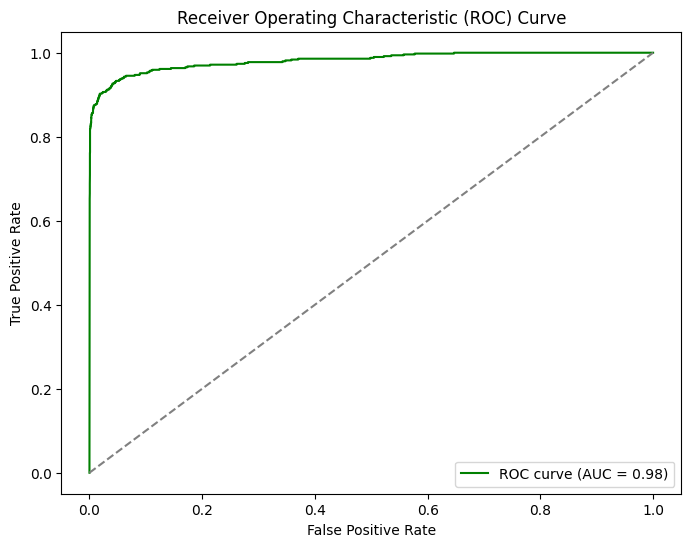

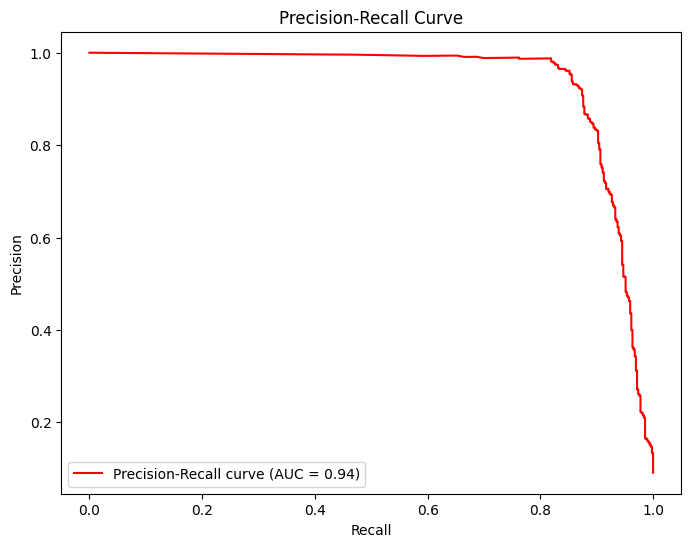

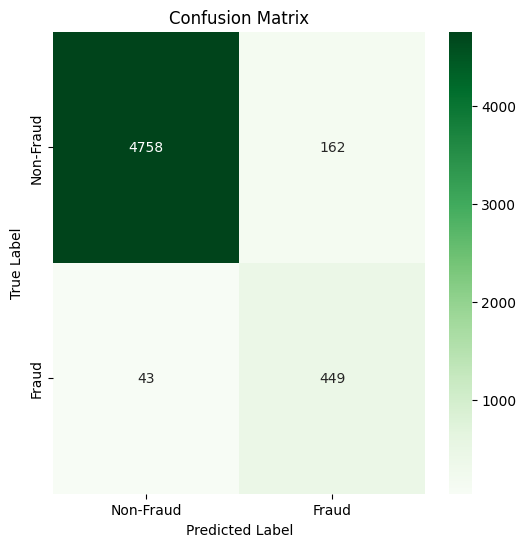

In [ ]:

graph_list = [graph_data]

# Get evaluation metrics
eval_results = test_dynamic(model, graph_list)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Accuracy:  {eval_results['accuracy']:.4f}")
print(f"Precision: {eval_results['precision']:.4f}")
print(f"Recall:    {eval_results['recall']:.4f}")
print(f"F1 Score:  {eval_results['f1']:.4f}")
print(f"ROC AUC:   {eval_results['roc_auc']:.4f}")
print(f"AUC PR:    {eval_results['auc_pr']:.4f}")

# Plot ROC and PR curves
fpr, tpr, _ = roc_curve(eval_results['y_true'], eval_results['y_prob'])
plot_roc_curve(fpr, tpr, eval_results['roc_auc'])

precision, recall, _ = precision_recall_curve(eval_results['y_true'], eval_results['y_prob'])
plot_pr_curve(precision, recall, eval_results['auc_pr'])

# Plot Confusion Matrix
plot_confusion_matrix(eval_results['confusion_matrix'])
